In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema, find_peaks
from scipy.io import loadmat
from peakdetect import peakdetect, zero_crossings
import filter as f
import mat73



In [4]:
# STOP REDOWNLOADING THIS
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00340/data.zip

--2020-09-03 01:41:19--  https://archive.ics.uci.edu/ml/machine-learning-databases/00340/data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3363163675 (3.1G) [application/x-httpd-php]
Saving to: ‘data.zip’

data.zip            100%[===================>]   3.13G  11.2MB/s    in 4m 47s  

2020-09-03 01:46:06 (11.2 MB/s) - ‘data.zip’ saved [3363163675/3363163675]



In [3]:
# STOP RELOADING THIS AS WELL
dat = mat73.loadmat(r'data/Part_1.mat')

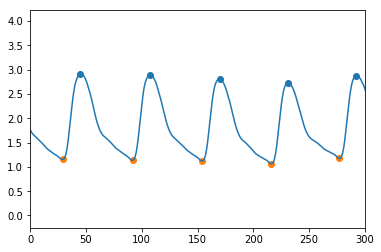

In [43]:
# Load the PPG data
ppg = dat['Part_1'][0][0]

peaks = PT_Detection(ppg)
xmax, ymax, xmin, ymin = peaks.detect() # peaks and troughs of the PPG signal
peaks.display(xmax, ymax, xmin, ymin)

values = Features(ppg)


In [30]:
print(xmin)

[29, 92, 154, 216, 277, 339, 400, 462, 522, 582, 643, 704, 764, 824, 884, 944, 1005, 1065, 1125, 1185, 1246, 1307, 1368, 1428, 1488, 1550, 1611, 1671, 1732, 1793, 1853, 1914, 1975, 2036, 2097, 2159, 2219, 2280, 2341, 2402, 2463, 2523, 2583, 2643, 2704, 2765, 2824, 2884, 2944, 3004, 3065, 3125, 3185, 3245, 3306, 3367, 3428, 3488, 3550, 3611, 3673, 3734, 3794, 3856, 3917, 3979, 4039, 4100, 4161, 4222, 4283, 4343, 4404, 4466, 4527, 4587, 4648, 4710, 4772, 4835, 4895, 4959, 4999, 5036, 5096, 5155, 5216, 5276, 5336, 5368, 5457, 5517, 5553, 5580, 5641, 5703, 5764, 5826, 5889, 5951, 6012, 6073, 6135, 6196, 6258, 6319, 6380, 6442, 6503, 6565, 6626, 6688, 6750, 6813, 6874, 6935, 6997, 7058, 7120, 7181, 7242, 7303, 7365, 7427, 7487, 7549, 7611, 7674, 7735, 7798, 7860, 7923, 7985, 8047, 8109, 8172, 8234, 8296, 8357, 8419, 8481, 8543, 8604, 8665, 8727, 8788, 8850, 8911, 8972, 9034, 9096, 9157, 9219, 9281, 9343, 9406, 9468, 9530, 9591, 9641, 9689, 9750, 9813, 9875, 9937, 9998, 10060, 10121, 10183, 

In [ ]:
# Looking for values closest to zeros here (not working)
# 1st Derivative 
dy = np.diff(ppg)
dx = 1
first = dy/dx

z = np.Inf
lookahead=1
zs = []
index = 0
'''test = [2,-1,-2,1,3,5,10,-3,-2,0]
for (x,y) in zip(np.arange(0,len(test))[:-lookahead], test[:-lookahead]):
    if abs(y) < abs(z):
        z = y
        zpos = x
    if abs(y) > abs(z) and z != np.Inf:
        if abs(dy[index:index+lookahead]).min() > z:
            zs.append([zpos,z])
            z = np.Inf
        if index+lookahead >= len(dy):
            break
        continue
    index += 1

    print(index)
plt.plot(test)
zpos = [k[0] for k in zs]
z = [k[1] for k in zs]
print(zs)
plt.grid(True)
plt.scatter(zpos,z)'''

In [9]:
# Clean Class
# Only detects the systolic peaks and the end of the period. Need to calculate the second derivative of the function in order
# to get to the diastolic peaks and the dicrotic notch
class PT_Detection: 
    
    def __init__(self, data):
        self.data = data
        
    # Detect the systolic/diastolic peaks and the dicrotic notch    
    def detect(self):
        max, min = peakdetect(self.data, np.arange(0,len(self.data)), lookahead=10)
        xmax = [p[0] for p in max]
        ymax = [p[1] for p in max]
        xmin = [p[0] for p in min]
        ymin = [p[1] for p in min]
        return xmax, ymax, xmin, ymin
        
    def display(self, xmax, ymax, xmin, ymin):
        plt.scatter(xmax,ymax)
        plt.scatter(xmin,ymin)
        plt.xlim(0,300)
        plt.plot(self.data)

In [51]:

if len(xmax) > len(xmin):
    xmax = xmax[:-1]
    ymax = ymax[:-1]

# Peak to Peak
p2p = np.diff(xmax)

# Pulse Interval
PI = np.diff(xmin)

# Systolic Amplitude
SA = np.array([])
for max in range(len(ymax)):
    difference = ymax[max] - ymin[max]
    SA = np.append(SA, difference)
    
# Average Value between max and min ==> 50% value of the systolic amplitude
Avg = np.array([])
for avg in range(len(ymax)):
    average = (ymax[max] + ymin[max]) / 2
    Avg = np.append(Avg, average)
    

# Pulse Width - at 50% of the systolic amplitude, get the width of the PPG wave from that x value to the next end of the PPG
# wave. 
# 1. Take the systolic amplitude and divide it by 50%, 2. Search through the first half of the PPG wave (before the systolic
# peak) and find the x value that corresponds to that y value of 50% of the systolic amplitude. 3. Search through the second 
# half of the PPG wave and find the x value that corresponds to that same y value. 4. Take the difference in x positions in 
# order to get the 50% pulse width
PW1 = np.array([])
PW2 = np.array([])
PW1x = np.array([])
PW2x = np.array([])
PW = np.array([])
i, xval1, xval2 = 0, 0, 0
for mid in Avg: # for each systolic amplitude -> for each PPG wavelength that there is
    u_candidate = np.array([]) # candidates on the way up to the systolic peak
    d_candidate = np.array([]) # candidates on the way down to the end of the wavelength
    height = mid # Want 50% pulse width
    if i >= len(xmin)-1:
        break

    for value in range(xmin[i], xmax[i]):
        u_candidate = np.append(u_candidate, abs((ppg[value] - height)))

    yval1 = ppg[xmin[i] + np.argmin(u_candidate)]
    xval1 = xmin[i] + np.argmin(u_candidate)
    PW1x = np.append(PW1x, xval1)
    PW1 = np.append(PW1, yval1)
    PW = np.append(PW, xval1)
    for value in range(xmax[i], xmin[i+1]):
        d_candidate = np.append(d_candidate, abs((ppg[value] - height)))
    yval2 = ppg[xmax[i] + np.argmin(d_candidate)]
    xval2 = xmax[i] + np.argmin(d_candidate)
    PW2 = np.append(PW2, yval2)
    PW2x = np.append(PW2x, xval2)
    PW = np.append(PW, xval2)
    
    i += 1


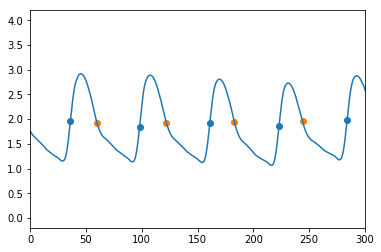

In [52]:
plt.scatter(PW1x, PW1)
plt.scatter(PW2x, PW2)
plt.xlim(0,300)
plt.plot(ppg)

In [32]:
# Clean Feature Class
class Features:
    def __init__(self, data):
        self.data = data
        extrema = PT_Detection(data)
        self.xmax, self.ymax, self.xmin, self.ymin = extrema.detect()
        # Set up the indices to match up properly
        if self.xmax[0] > self.xmin[0]:
            self.xmin = self.xmin[1:]
            self.ymin = self.ymin[1:]
        if len(self.xmax) > len(self.xmin):
            self.xmax = self.xmax[:-1]
            self.ymax = self.ymax[:-1]
        
    def p2p(self):
        return np.diff(xmax)
    
    def p_i(self):
        return np.diff(xmin)
    
    def SA(self):
        SA = np.array([])
        for max in range(len(self.ymax)):
            difference = self.ymax[max] - self.ymin[max]
            SA = np.append(SA, difference)
        return SA
    
    def pwidth(self):
        PW1 = np.array([])
        PW2 = np.array([])
        PW1x = np.array([])
        PW2x = np.array([])
        PW = np.array([])
        i, xval1, xval2 = 0, 0, 0
        for mid in Avg: # for each systolic amplitude -> for each PPG wavelength that there is
            u_candidate = np.array([]) # candidates on the way up to the systolic peak
            d_candidate = np.array([]) # candidates on the way down to the end of the wavelength
            height = mid # Want 50% pulse width
            if i >= len(xmin)-1:
                break

            for value in range(self.xmin[i], self.xmax[i+1]):
                u_candidate = np.append(u_candidate, abs((self.data[value] - height)))

            yval1 = self.data[self.xmin[i] + np.argmin(u_candidate)]
            xval1 = self.xmin[i] + np.argmin(u_candidate)
            PW1x = np.append(PW1x, xval1)
            PW1 = np.append(PW1, yval1)
            PW = np.append(PW, xval1)

            for value in range(self.xmax[i+1], self.xmin[i+1]):
                d_candidate = np.append(d_candidate, abs((ppg[value] - height)))
            yval2 = self.data[self.xmax[i+1] + np.argmin(d_candidate)]
            xval2 = self.xmax[i+1] + np.argmin(d_candidate)
            PW2 = np.append(PW2, yval2)
            PW2x = np.append(PW2x, xval2)
            PW = np.append(PW, xval2)
            i += 1
        return np.diff(PW)
        